In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
import datetime
from sklearn import metrics

In [2]:
import statsmodels.formula.api as smf
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

### UDF's

In [3]:
# Create Data audit Report for continuous variables
def continuous_var_summary(x):
    return pd.Series([x.count(), x.isnull().sum(), x.sum(), x.mean(), x.median(),  
                      x.std(), x.var(), x.min(), x.quantile(0.01), x.quantile(0.05),
                          x.quantile(0.10),x.quantile(0.25),x.quantile(0.50),x.quantile(0.75), 
                              x.quantile(0.90),x.quantile(0.95), x.quantile(0.99),x.max()], 
                  index = ['N', 'NMISS', 'SUM', 'MEAN','MEDIAN', 'STD', 'VAR', 'MIN', 'P1', 
                               'P5' ,'P10' ,'P25' ,'P50' ,'P75' ,'P90' ,'P95' ,'P99' ,'MAX'])

In [4]:
# Create Data audit Report for categorical variables
def categorical_var_summary(x):
    Mode = x.value_counts().sort_values(ascending = False)[0:1].reset_index()
    return pd.Series([x.count(), x.isnull().sum(), Mode.iloc[0, 0], Mode.iloc[0, 1], 
                          round(Mode.iloc[0, 1] * 100/x.count(), 2)], 
                  index = ['N', 'NMISS', 'MODE', 'FREQ', 'PERCENT'])

In [5]:
# Missing value imputation for categorical and continuous variables
def missing_imputation(x, stats = 'mean'):
    if (x.dtypes == 'float64') | (x.dtypes == 'int64'):
        x = x.fillna(x.mean()) if stats == 'mean' else x.fillna(x.median())
    return x

In [6]:
# An utility function to create dummy variable
def create_dummies(df, colname):
    col_dummies = pd.get_dummies(df[colname], prefix = colname, drop_first = True)
    df = pd.concat([df, col_dummies], axis = 1)
    df.drop(colname, axis = 1, inplace = True )
    return df

### data import and inspection

In [7]:
consumptions=pd.read_excel('C:/Users/avnis/Case study/Machine Learning/CS 11/CreditConsumptionData.xlsx')
behaviour=pd.read_excel('C:/Users/avnis/Case study/Machine Learning/CS 11/CustomerBehaviorData.xlsx')
Demographics=pd.read_excel('C:/Users/avnis/Case study/Machine Learning/CS 11/CustomerDemographics.xlsx')

In [8]:
data1=pd.merge(left=behaviour,right=Demographics,how='left',on='ID')
data=pd.merge(left=data1,right=consumptions,how='left',on='ID')

In [9]:
data.shape

(20000, 49)

In [10]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20000 entries, 0 to 19999
Data columns (total 49 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   ID                            20000 non-null  int64  
 1   cc_cons_apr                   20000 non-null  float64
 2   dc_cons_apr                   20000 non-null  float64
 3   cc_cons_may                   19999 non-null  float64
 4   dc_cons_may                   20000 non-null  float64
 5   cc_cons_jun                   20000 non-null  float64
 6   dc_cons_jun                   19999 non-null  float64
 7   cc_count_apr                  19999 non-null  float64
 8   cc_count_may                  20000 non-null  int64  
 9   cc_count_jun                  20000 non-null  int64  
 10  dc_count_apr                  20000 non-null  int64  
 11  dc_count_may                  20000 non-null  int64  
 12  dc_count_jun                  20000 non-null  int64  
 13  c

In [11]:
data.isna().sum()

ID                                 0
cc_cons_apr                        0
dc_cons_apr                        0
cc_cons_may                        1
dc_cons_may                        0
cc_cons_jun                        0
dc_cons_jun                        1
cc_count_apr                       1
cc_count_may                       0
cc_count_jun                       0
dc_count_apr                       0
dc_count_may                       0
dc_count_jun                       0
card_lim                           0
personal_loan_active               0
vehicle_loan_active                0
personal_loan_closed               1
vehicle_loan_closed                0
investment_1                       0
investment_2                       0
investment_3                       2
investment_4                       0
debit_amount_apr                   0
credit_amount_apr                  0
debit_count_apr                    1
credit_count_apr                   0
max_credit_amount_apr              0
d

#### Step 2. Exploratory Data Analysis

In [12]:
data.drop('ID', axis = 1, inplace =True) # drop column "ID"


In [13]:
#separating continuous and categorical data
numerical_features=['cc_cons_apr', 'dc_cons_apr', 'cc_cons_may', 'dc_cons_may',
                    'cc_cons_jun', 'dc_cons_jun', 'cc_count_apr', 'cc_count_may',
                    'cc_count_jun', 'dc_count_apr', 'dc_count_may', 'dc_count_jun',
                    'investment_1','investment_2', 'investment_3',
                    'investment_4', 'debit_amount_apr',
                    'credit_amount_apr', 'debit_count_apr', 'credit_count_apr',
                    'max_credit_amount_apr', 'debit_amount_may', 'credit_amount_may',
                    'credit_count_may', 'debit_count_may', 'max_credit_amount_may',
                    'debit_amount_jun', 'credit_amount_jun', 'credit_count_jun',
                    'debit_count_jun', 'max_credit_amount_jun','emi_active', 'age',
                    'Emp_Tenure_Years','Avg_days_between_transaction',
                    'Tenure_with_Bank']

categorical=['personal_loan_active', 'vehicle_loan_active',
             'personal_loan_closed', 'vehicle_loan_closed','loan_enq',
             'account_type','gender','Income','region_code','NetBanking_Flag']

In [14]:
data_continuous=data[numerical_features]
data_categorical=data[categorical]

In [15]:
#summary for continuous variables
data_continuous.apply(continuous_var_summary)

,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,...,debit_amount_jun,credit_amount_jun,credit_count_jun,debit_count_jun,max_credit_amount_jun,emi_active,age,Emp_Tenure_Years,Avg_days_between_transaction,Tenure_with_Bank
N,2.000000e+04,2.000000e+04,1.999900e+04,2.000000e+04,2.000000e+04,1.999900e+04,19999.000000,20000.000000,20000.000000,20000.000000,...,2.000000e+04,2.000000e+04,20000.000000,20000.000000,2.000000e+04,1.999900e+04,20000.000000,20000.000000,19997.000000,20000.000000
NMISS,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000,0.000000,0.000000,0.000000,...,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,1.000000e+00,0.000000,0.000000,3.000000,0.000000
SUM,3.571398e+08,1.626091e+08,3.237511e+08,1.540485e+08,2.427161e+08,1.421871e+08,832191.000000,671382.000000,829404.000000,341434.000000,...,1.562456e+09,1.576339e+09,398109.000000,890582.000000,1.056997e+09,3.079620e+08,953446.000000,304345.000000,220862.000000,109921.000000
MEAN,1.785699e+04,8.130453e+03,1.618836e+04,7.702427e+03,1.213581e+04,7.109708e+03,41.611631,33.569100,41.470200,17.071700,...,7.812280e+04,7.881693e+04,19.905450,44.529100,5.284985e+04,1.539887e+04,47.672300,15.217250,11.044757,5.496050
MEDIAN,1.021464e+04,3.964750e+03,8.635230e+03,3.791720e+03,6.656800e+03,3.326000e+03,10.000000,23.000000,35.000000,7.000000,...,4.572505e+04,4.618300e+04,7.000000,37.000000,3.025000e+04,3.934660e+03,40.000000,9.900000,11.000000,6.000000
STD,2.515888e+04,1.457219e+04,2.651068e+04,1.789273e+04,1.879098e+04,1.331394e+04,97.835475,50.316925,46.825658,19.285322,...,2.448983e+05,1.569872e+05,27.055323,35.080453,1.343175e+05,1.202541e+05,30.359771,20.481455,5.480552,2.870452
VAR,6.329692e+08,2.123487e+08,7.028162e+08,3.201499e+08,3.531011e+08,1.772609e+08,9571.780105,2531.792915,2192.642244,371.923655,...,5.997518e+10,2.464499e+10,731.990510,1230.638185,1.804120e+10,1.446104e+10,921.715698,419.489979,30.036454,8.239496
MIN,2.530000e+02,1.935000e+01,1.570000e+02,2.200000e+01,6.500000e+01,6.200000e+01,1.000000,1.000000,1.000000,1.000000,...,5.230000e+00,1.188000e+01,1.000000,0.000000,6.000000e-02,0.000000e+00,25.000000,0.500000,2.000000,1.000000
P1,6.419886e+02,1.531286e+02,5.094900e+02,1.521000e+02,3.340000e+02,1.909500e+02,1.000000,1.000000,1.000000,1.000000,...,1.077000e+03,2.960000e+02,1.000000,0.000000,1.600000e+02,2.673900e+01,27.000000,0.900000,2.000000,1.000000
P5,1.219000e+03,3.780000e+02,1.035774e+03,4.109700e+02,8.251010e+02,3.900000e+02,1.000000,2.000000,3.000000,1.000000,...,6.972000e+03,4.020900e+03,2.000000,2.000000,1.679500e+03,1.979500e+02,28.000000,1.700000,2.000000,1.000000



#### Outlier treatment

In [16]:
data_continuous=data_continuous.apply(lambda x:x.clip(lower=x.quantile(0.01),
                                                      upper=x.quantile(0.99)))

#### missing value treatment

In [17]:
data_continuous.isna().sum()*100/data_continuous.isna().count()

cc_cons_apr                     0.000
dc_cons_apr                     0.000
cc_cons_may                     0.005
dc_cons_may                     0.000
cc_cons_jun                     0.000
dc_cons_jun                     0.005
cc_count_apr                    0.005
cc_count_may                    0.000
cc_count_jun                    0.000
dc_count_apr                    0.000
dc_count_may                    0.000
dc_count_jun                    0.000
investment_1                    0.000
investment_2                    0.000
investment_3                    0.010
investment_4                    0.000
debit_amount_apr                0.000
credit_amount_apr               0.000
debit_count_apr                 0.005
credit_count_apr                0.000
max_credit_amount_apr           0.000
debit_amount_may                0.000
credit_amount_may               0.000
credit_count_may                0.000
debit_count_may                 0.000
max_credit_amount_may           0.000
debit_amount

In [18]:
data_continuous=data_continuous.apply(missing_imputation)

In [19]:
data_categorical=data_categorical.apply(lambda x: x.fillna(x.value_counts().index[0]))

In [20]:
data_categorical

,personal_loan_active,vehicle_loan_active,personal_loan_closed,vehicle_loan_closed,loan_enq,account_type,gender,Income,region_code,NetBanking_Flag
0,1,1,1.0,1,Y,current,M,MEDIUM,956.0,1
1,1,1,1.0,1,Y,current,M,LOW,966.0,1
2,1,1,1.0,1,Y,current,M,MEDIUM,505.0,1
3,1,1,1.0,1,Y,current,M,LOW,631.0,0
4,1,1,1.0,1,Y,saving,M,MEDIUM,698.0,0
...,...,...,...,...,...,...,...,...,...,...
19995,1,1,1.0,1,Y,current,M,MEDIUM,523.0,0
19996,1,1,1.0,1,Y,current,M,MEDIUM,723.0,1
19997,1,1,1.0,1,Y,current,M,HIGH,863.0,1
19998,1,1,1.0,1,Y,current,M,MEDIUM,882.0,0


In [21]:
for c in data_categorical.columns:
    data_categorical=create_dummies(data_categorical,c)

### combine the continuous and categorical data

In [22]:
data_categorical.shape

(20000, 214)

In [23]:
data_new=pd.concat([data_continuous,data_categorical,data.cc_cons],axis=1)

In [24]:
data_new

,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,...,region_code_963.0,region_code_964.0,region_code_965.0,region_code_966.0,region_code_968.0,region_code_969.0,region_code_970.0,region_code_974.0,NetBanking_Flag_1,cc_cons
0,3412.600,2909.34,1077.36,3084.50,4615.97,6693.00,19.0,10,2,53,...,0,0,0,0,0,0,0,0,1,13434.0
1,18133.760,3877.00,6123.78,5597.43,64620.00,6117.00,4.0,60,1,4,...,0,0,0,1,0,0,0,0,1,449.0
2,6363.650,735.49,8799.00,13768.00,38266.00,2638.00,2.0,83,47,4,...,0,0,0,0,0,0,0,0,1,11968.0
3,12765.660,4429.16,16745.86,6360.00,29063.97,3711.00,12.0,2,16,24,...,0,0,0,0,0,0,0,0,0,32029.0
4,27819.700,1944.00,7006.50,2228.50,1096.25,1065.00,15.0,13,61,7,...,0,0,0,0,0,0,0,0,0,16394.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,4641.500,5979.58,6008.61,4410.00,41743.00,1884.00,26.0,1,4,1,...,0,0,0,0,0,0,0,0,0,NaN
19996,4994.450,2805.37,23214.00,5870.00,1041.00,1008.73,37.0,56,50,18,...,0,0,0,0,0,0,0,0,1,NaN
19997,3262.145,2871.00,7335.25,11774.04,4130.00,1413.00,12.0,77,1,1,...,0,0,0,0,0,0,0,0,1,NaN
19998,12824.010,4866.00,12242.48,284.00,15132.77,37911.00,67.0,1,4,1,...,0,0,0,0,0,0,0,0,0,NaN


#### Splitting the data in training and predict

In [25]:
predict_data=data_new[data_new.cc_cons.isnull()]
training_data=data_new[~data_new['cc_cons'].isnull()]

In [26]:
feature_columns=data_new.columns.difference(['cc_cons'])

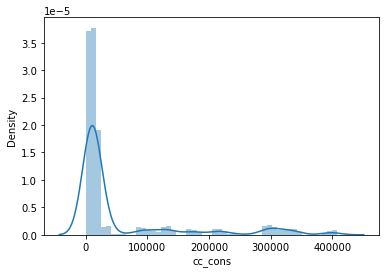

In [27]:
sns.distplot(data_new['cc_cons'])
plt.show()

In [28]:
corrm = data_new.corr()
corrm.to_excel('D:/corrm.xlsx')


### Feature Selection

In [32]:
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE

In [33]:
linreg=LinearRegression()

In [34]:
rfe=RFE(linreg,n_features_to_select=20).fit(training_data[feature_columns],
                                                            training_data['cc_cons'])

In [37]:
RFE_Output = pd.DataFrame([feature_columns, rfe.support_, rfe.ranking_]).T
RFE_Output.columns = ['Features', 'support', 'ranking']

In [38]:
RFE_Output.sort_values(by='ranking')

,Features,support,ranking
75,region_code_353.0,True,1
54,region_code_266.0,True,1
179,region_code_736.0,True,1
144,region_code_608.0,True,1
133,region_code_573.0,True,1
...,...,...,...
27,debit_amount_jun,False,227
35,investment_2,False,228
26,debit_amount_apr,False,229
28,debit_amount_may,False,230


In [42]:
X_final=training_data[feature_columns[rfe.support_]]
Y_final=training_data['cc_cons']

#### Data split for training and test

In [29]:
# import the package
from sklearn.model_selection import train_test_split

In [55]:
# get training and testing datasets
train_X,test_X,train_Y,test_Y=train_test_split(X_final,Y_final,
                                               random_state=123,train_size=0.7)

### Build Linear Regression model

In [44]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV

#### UDF for RMSPE

In [45]:

def RMSPE(y_true,y_pred):
    rmspe = (np.sqrt(np.mean(np.square((y_true - y_pred) / y_true)))) * 100
    return rmspe

#### Fine tuning paramter


In [63]:
### set the tuning parameters
tune_param={'max_depth':range(10,20),
            'min_samples_leaf':range(1,11)
           }

#build the model
tree1=GridSearchCV(DecisionTreeRegressor(random_state=1),
                       tune_param,
                       verbose=True,
                       cv=5,
                       scoring='neg_mean_squared_error',
                  n_jobs=-1).fit(train_X,train_Y)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [64]:
tree1.best_params_

{'max_depth': 10, 'min_samples_leaf': 4}

In [69]:
#using best paramters we design the new model
tree2=DecisionTreeRegressor(max_depth=10,min_samples_leaf=4,random_state=1).fit(train_X,train_Y)

In [70]:
#predciting the credit card consumption based on the model
ypred_train=tree2.predict(train_X)
ypred_test=tree2.predict(test_X)

In [71]:
metrics.mean_absolute_error(train_Y,ypred_train)

69497.43898666174

In [72]:
metrics.mean_absolute_error(test_Y,ypred_test)

70101.24669906507

In [73]:
##scoring on basis of mean absolute percenatge error and root mean absolute oercentage error
print('RMSPE of Train data:',(np.sqrt(np.mean(np.square((train_Y - ypred_train) /(0.005+train_Y)))))*100)
print('RMSPE of Test data:',(np.sqrt(np.mean(np.square((test_Y - ypred_test) /(0.005+test_Y)))))*100)

RMSPE of Train data: 10687867.72571768
RMSPE of Test data: 40577.69221794984


### Predicting data for target variable having missing value

In [81]:
X_predict=predict_data[feature_columns[rfe.support_]]

In [84]:
cc_cons_predict=tree2.predict(X_predict)

In [85]:
prediction=pd.Series(cc_cons_predict)

In [86]:
predict_data['Predictions']=prediction.values

In [90]:
prediction

0       54759.001052
1       54759.001052
2       54759.001052
3       54759.001052
4       54759.001052
            ...     
4995    54759.001052
4996    54759.001052
4997    54759.001052
4998    54759.001052
4999    54759.001052
Length: 5000, dtype: float64

In [89]:
predict_data

,cc_cons_apr,dc_cons_apr,cc_cons_may,dc_cons_may,cc_cons_jun,dc_cons_jun,cc_count_apr,cc_count_may,cc_count_jun,dc_count_apr,...,region_code_964.0,region_code_965.0,region_code_966.0,region_code_968.0,region_code_969.0,region_code_970.0,region_code_974.0,NetBanking_Flag_1,cc_cons,Predictions
15000,2795.450,1290.00,6141.05,676.50,9146.10,15479.00,4.0,10,4,47,...,0,0,0,0,0,0,0,1,NaN,54759.001052
15001,29405.130,1640.00,1670.00,2463.92,10947.50,956.00,3.0,10,4,50,...,0,0,0,0,0,0,0,0,NaN,54759.001052
15002,5985.200,6189.00,2696.09,766.00,716.00,4133.22,7.0,30,5,24,...,0,0,0,0,0,0,0,1,NaN,54759.001052
15003,2105.930,18225.00,34763.56,167.00,4260.27,20185.00,1.0,99,71,5,...,0,0,0,0,0,0,0,1,NaN,54759.001052
15004,3269.000,3532.00,3158.40,2699.77,3373.48,5120.00,2.0,10,47,5,...,0,0,0,0,0,0,0,1,NaN,54759.001052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,4641.500,5979.58,6008.61,4410.00,41743.00,1884.00,26.0,1,4,1,...,0,0,0,0,0,0,0,0,NaN,54759.001052
19996,4994.450,2805.37,23214.00,5870.00,1041.00,1008.73,37.0,56,50,18,...,0,0,0,0,0,0,0,1,NaN,54759.001052
19997,3262.145,2871.00,7335.25,11774.04,4130.00,1413.00,12.0,77,1,1,...,0,0,0,0,0,0,0,1,NaN,54759.001052
19998,12824.010,4866.00,12242.48,284.00,15132.77,37911.00,67.0,1,4,1,...,0,0,0,0,0,0,0,0,NaN,54759.001052
